### Librerías


In [1]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *


Se genera un dataframe que concatene las bases de datos "seed" de las mujeres y los hombres. Los seed basicamente es una nomenclatura que identifica la región del equipo

In [2]:
df_seeds = pd.concat([
    pd.read_csv("MNCAATourneySeeds.csv"),
    pd.read_csv("WNCAATourneySeeds.csv"),
], ignore_index=True)

df_seeds.tail(30)

,Season,Seed,TeamID
4068,2023,Y05,3450
4069,2023,Y06,3276
4070,2023,Y07,3301
4071,2023,Y08,3329
4072,2023,Y09,3274
4073,2023,Y10,3343
4074,2023,Y11,3424
4075,2023,Y12,3195
4076,2023,Y13,3156
4077,2023,Y14,3218


In [3]:
df_seeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4098 entries, 0 to 4097
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Season  4098 non-null   int64 
 1   Seed    4098 non-null   object
 2   TeamID  4098 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 96.2+ KB


In [4]:
df_seeds.isnull().count()

Season    4098
Seed      4098
TeamID    4098
dtype: int64

A continuación se concatenan los resultados tanto para hombres como para mujeres de las temporadas y se exluyen los valores NumOT y WLoc toda vez que no son útiles para el análisis

In [5]:
df_season_results = pd.concat([
    pd.read_csv("MRegularSeasonCompactResults.csv"),
    pd.read_csv("WRegularSeasonCompactResults.csv"),
], ignore_index=True)

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,20,1228,81,1328,64
1,1985,25,1106,77,1354,70
2,1985,25,1112,63,1223,56
3,1985,25,1165,70,1432,54
4,1985,25,1192,86,1447,74


In [6]:
df_season_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307855 entries, 0 to 307854
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   Season   307855 non-null  int64
 1   DayNum   307855 non-null  int64
 2   WTeamID  307855 non-null  int64
 3   WScore   307855 non-null  int64
 4   LTeamID  307855 non-null  int64
 5   LScore   307855 non-null  int64
dtypes: int64(6)
memory usage: 14.1 MB


In [7]:
df_season_results.describe()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
count,307855.000000,307855.000000,307855.000000,307855.000000,307855.000000,307855.000000
mean,2007.565016,73.131594,2105.995917,74.739241,2103.407003,61.740881
std,10.118320,34.481003,987.829906,11.917605,990.160767,11.607099
min,1985.000000,0.000000,1101.000000,30.000000,1101.000000,11.000000
25%,2000.000000,43.000000,1261.000000,66.000000,1254.000000,54.000000
50%,2009.000000,75.000000,1413.000000,74.000000,1408.000000,61.000000
75%,2016.000000,103.000000,3245.000000,82.000000,3245.000000,69.000000
max,2023.000000,132.000000,3477.000000,186.000000,3477.000000,150.000000


Una medida super importante para hacer el análisis es delimitar cual es la diferencia que existe entre el puntaje del equipo ganador Wscore y el perdedor Lscore, el cuál será siempre un valor positivo. Se hará esta verificación.

In [8]:
df_season_results['Diferencia Puntaje'] = df_season_results['WScore'] - df_season_results['LScore']
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Diferencia Puntaje
0,1985,20,1228,81,1328,64,17
1,1985,25,1106,77,1354,70,7
2,1985,25,1112,63,1223,56,7
3,1985,25,1165,70,1432,54,16
4,1985,25,1192,86,1447,74,12


Como se puede percibir a continuación nuestra teoría es válida y no hay datos erroneos para el análisis. No existe una diferencia de puntaje W-L negativa

In [9]:
df_season_results[df_season_results['Diferencia Puntaje']<0]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Diferencia Puntaje


Analizamos el data frame si contiene datos nulos, como se puede percibir a continuación no hay presencia de los mismos. Todas las variables tienen 307855 datos.

In [10]:
df_season_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307855 entries, 0 to 307854
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   Season              307855 non-null  int64
 1   DayNum              307855 non-null  int64
 2   WTeamID             307855 non-null  int64
 3   WScore              307855 non-null  int64
 4   LTeamID             307855 non-null  int64
 5   LScore              307855 non-null  int64
 6   Diferencia Puntaje  307855 non-null  int64
dtypes: int64(7)
memory usage: 16.4 MB


A continuación se genera mediante la función groupby un agrupamiento teniendo en cuenta la condición W=win (ganar) y L=lose (perder), así se podrán diferenciar el equipo ganador y perdedor,adicionalmente, se podrá consolidar por temporada. Análogamente, se podrá determinar la media de la diferencia de puntajes cuando se gana y pierde

In [11]:
Partidas_ganadas = df_season_results.groupby(['Season', 'WTeamID']).count()
Partidas_ganadas = Partidas_ganadas.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "Partidas Ganadas", "WTeamID": "TeamID"})

In [12]:
Partidas_perdidas = df_season_results.groupby(['Season', 'LTeamID']).count()
Partidas_perdidas = Partidas_perdidas.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "Partidas Perdidas", "LTeamID": "TeamID"})

In [13]:
Difgan = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
Difgan = Difgan[['Season', 'WTeamID', 'Diferencia Puntaje']].rename(columns={"Diferencia Puntaje": "Media Diferencia Puntaje Partidas ganadas", "WTeamID": "TeamID"})

In [14]:
Difper = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
Difper = Difper[['Season', 'LTeamID', 'Diferencia Puntaje']].rename(columns={"Diferencia Puntaje": "Media Diferencia Puntaje perdidas", "LTeamID": "TeamID"})

In [15]:
df_features_season_ganadores = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_perdedores = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [16]:
df_features_season = pd.concat([df_features_season_ganadores, df_features_season_perdedores], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [17]:
df_features_season = df_features_season.merge(Partidas_ganadas, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(Partidas_perdidas, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(Difgan, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(Difper, on=['Season', 'TeamID'], how='left')

In [18]:
df_features_season.fillna(0, inplace=True)

Así a su vez, en primera instancia se podría pensar en que, teniendo el puntaje de los partidos jugados por cada equipo, se podría analizar la media de la diferencia de los partidos cuando se gana y cuando se pierde, esto genera una variable de importancia para cada equipo. A continuación se realiza un ejemplo en aras de demostrar la relevancia de este dato.

Media diferencia Equipo A Gana = 12 puntos
Media diferencia Equipo B Gana = 7 puntos
Media diferencia Equipo A Pierde =2 puntos
Media diferencia Equipo B Pierde = 5 puntos

De esta manera en un enfrentamiento entre el equipo A y el B, el equipo A ganaría en principio toda vez que, normalmente cuando gana hace más puntos que el equipo B y cuando pierde recibe menos puntos que este.


In [19]:
df_features_season.head()

,Season,TeamID,Partidas Ganadas,Partidas Perdidas,Media Diferencia Puntaje Partidas ganadas,Media Diferencia Puntaje perdidas
0,1985,1102,5.0,19.0,10.000000,9.947368
1,1985,1103,9.0,14.0,7.555556,9.857143
2,1985,1104,21.0,9.0,13.190476,4.777778
3,1985,1106,10.0,14.0,9.500000,13.285714
4,1985,1108,19.0,6.0,13.842105,10.666667


La suma de las partidas ganadas debe ser igual a la suma de las partidas pérdidas.

In [20]:
if(df_features_season["Partidas Perdidas"].sum()==df_features_season["Partidas Ganadas"].sum()):
  print("Está bueno")

Está bueno


In [21]:
df_features_season['Proporcion_ganadas'] = df_features_season['Partidas Ganadas'] / (df_features_season['Partidas Ganadas'] + df_features_season['Partidas Perdidas'])
df_features_season['Promedio diferencia'] = (
    (df_features_season['Partidas Ganadas'] * df_features_season['Media Diferencia Puntaje Partidas ganadas'] -
    df_features_season['Partidas Perdidas'] * df_features_season['Media Diferencia Puntaje perdidas'])
    / (df_features_season['Partidas Ganadas'] + df_features_season['Partidas Perdidas'])
)

In [22]:
df_features_season

,Season,TeamID,Partidas Ganadas,Partidas Perdidas,Media Diferencia Puntaje Partidas ganadas,Media Diferencia Puntaje perdidas,Proporcion_ganadas,Promedio diferencia
0,1985,1102,5.0,19.0,10.000000,9.947368,0.208333,-5.791667
1,1985,1103,9.0,14.0,7.555556,9.857143,0.391304,-3.043478
2,1985,1104,21.0,9.0,13.190476,4.777778,0.700000,7.800000
3,1985,1106,10.0,14.0,9.500000,13.285714,0.416667,-3.791667
4,1985,1108,19.0,6.0,13.842105,10.666667,0.760000,7.960000
...,...,...,...,...,...,...,...,...
21423,2023,3473,1.0,24.0,9.000000,18.500000,0.040000,-17.400000
21424,2023,3474,5.0,21.0,10.200000,20.523810,0.192308,-14.615385
21425,2023,3475,9.0,17.0,13.000000,12.176471,0.346154,-3.461538
21426,2023,3476,8.0,20.0,10.125000,12.800000,0.285714,-6.250000


Para que sea más sencillo de trabajar solo se dejarán como medidas relevantes, proporción ganadas y promedio diferencia.


In [23]:
df_features_season.drop(['Partidas Ganadas', 'Partidas Perdidas', 'Media Diferencia Puntaje Partidas ganadas', 'Media Diferencia Puntaje perdidas'], axis=1, inplace=True)

In [24]:
df_torneo_resultados = pd.concat([
    pd.read_csv("WNCAATourneyCompactResults.csv"),
    pd.read_csv("MNCAATourneyCompactResults.csv"),
], ignore_index=True)
df_torneo_resultados.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

Es importante este apartado del código, dado que se podría tener en cuenta toda la data, o desde un año en específico, por relevancia, se podrían tomar los datos desde el 2015 los cuales son los mas recientes y que se ajustan al comportamiento esperado.

In [25]:
dftor = df_torneo_resultados.copy()
dftor = dftor[dftor['Season'] >= 2015].reset_index(drop=True)

dftor.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2015,137,3116,57,3321,55
1,2015,137,3124,77,3322,36
2,2015,137,3143,78,3455,66
3,2015,137,3173,78,3235,66
4,2015,137,3177,79,3278,72


In [26]:
dftor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913 entries, 0 to 912
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Season   913 non-null    int64
 1   DayNum   913 non-null    int64
 2   WTeamID  913 non-null    int64
 3   WScore   913 non-null    int64
 4   LTeamID  913 non-null    int64
 5   LScore   913 non-null    int64
dtypes: int64(6)
memory usage: 42.9 KB


In [27]:
dftor = pd.merge(
    dftor,
    df_seeds,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [28]:
dftor = pd.merge(
    dftor,
    df_seeds,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [29]:
dftor.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2015,137,3116,57,3321,55,Z10,Z07
1,2015,137,3124,77,3322,36,Z02,Z15
2,2015,137,3143,78,3455,66,W04,W13
3,2015,137,3173,78,3235,66,W07,W10
4,2015,137,3177,79,3278,72,Z09,Z08


A la semilla se le quitará la zona es decir "Z,W,etc" para un mejor tratamiento

In [30]:
def borrar_semilla(seed):
    return int(re.sub("[^0-9]", "", seed))

In [31]:
dftor['SeedW'] = dftor['SeedW'].apply(borrar_semilla)
dftor['SeedL'] = dftor['SeedL'].apply(borrar_semilla)

In [32]:
dftor.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2015,137,3116,57,3321,55,10,7
1,2015,137,3124,77,3322,36,2,15
2,2015,137,3143,78,3455,66,4,13
3,2015,137,3173,78,3235,66,7,10
4,2015,137,3177,79,3278,72,9,8


A continuación lo que se genera es que se consolidan las bases de datos y se disgrega tanto para el equipo ganador como para el perdedor la Medida de la diferencia del puntaje y la proporción de ganadas

In [33]:
dftor = pd.merge(
    dftor,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'Partidas Ganadas': 'Partidas GanadasW',
    'Partidas Perdidas': 'Partidas PerdidasW',
    'Media Diferencia Puntaje Partidas ganadas': 'Media Diferencia Puntaje Partidas ganadasW',
    'Media Diferencia Puntaje perdidas': 'Media Diferencia Puntaje perdidasW',
    'Proporcion_ganadas': 'Proporcion_ganadasW',
    'Promedio diferencia': 'Promedio diferenciaW',
}).drop(columns='TeamID', axis=1)

In [34]:
dftor = pd.merge(
    dftor,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'Partidas Ganadas': 'Partidas GanadasL',
    'Partidas Perdidas': 'Partidas PerdidasL',
    'Media Diferencia Puntaje Partidas ganadas': 'Media Diferencia Puntaje Partidas ganadasL',
    'Media Diferencia Puntaje perdidas': 'Media Diferencia Puntaje perdidasL',
    'Proporcion_ganadas': 'Proporcion_ganadasL',
    'Promedio diferencia': 'Promedio diferenciaL',
}).drop(columns='TeamID', axis=1)

In [35]:
dftor.head(130)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,Proporcion_ganadasW,Promedio diferenciaW,Proporcion_ganadasL,Promedio diferenciaL
0,2015,137,3116,57,3321,55,10,7,0.566667,4.900000,0.741935,9.419355
1,2015,137,3124,77,3322,36,2,15,0.909091,20.666667,0.517241,-3.275862
2,2015,137,3143,78,3455,66,4,13,0.718750,7.343750,0.878788,13.424242
3,2015,137,3173,78,3235,66,7,10,0.806452,11.935484,0.600000,6.333333
4,2015,137,3177,79,3278,72,9,8,0.787879,16.909091,0.718750,4.593750
...,...,...,...,...,...,...,...,...,...,...,...,...
125,2016,155,3163,82,3393,51,1,4,1.000000,39.687500,0.781250,13.000000
126,2017,137,3113,73,3277,61,8,9,0.612903,6.161290,0.656250,7.031250
127,2017,137,3166,76,3405,49,7,10,0.766667,8.066667,0.750000,8.281250
128,2017,137,3177,88,3320,67,7,10,0.787879,13.727273,0.741935,9.387097


In [36]:
def partidosperdidos(dftor):
    win_rename = {
        "WTeamID": "TeamIdA",
        "WScore" : "ScoreA",
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in dftor.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in dftor.columns if c.endswith('L')})

    lose_rename = {
        "WTeamID": "TeamIdB",
        "WScore" : "ScoreB",
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in dftor.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in dftor.columns if c.endswith('L')})

    win_df = dftor.copy()
    lose_df = dftor.copy()

    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)

    return pd.concat([win_df, lose_df], axis=0, sort=False)

In [37]:
dftor = partidosperdidos(dftor)

In [38]:
dftor.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,Proporcion_ganadasA,Promedio diferenciaA,Proporcion_ganadasB,Promedio diferenciaB
0,2015,137,3116,57,3321,55,10,7,0.566667,4.900000,0.741935,9.419355
1,2015,137,3124,77,3322,36,2,15,0.909091,20.666667,0.517241,-3.275862
2,2015,137,3143,78,3455,66,4,13,0.718750,7.343750,0.878788,13.424242
3,2015,137,3173,78,3235,66,7,10,0.806452,11.935484,0.600000,6.333333
4,2015,137,3177,79,3278,72,9,8,0.787879,16.909091,0.718750,4.593750


Se buscará generar una diferencia entre los promedios del equipo A y B, así de esta manera si genera un valor positivo significaría que existiría mayor probabilidad de ganar.


In [39]:
columnas_diferencia= ['Proporcion_ganadas', 'Promedio diferencia',]

for col in columnas_diferencia:
    dftor[col + 'Diff'] = dftor[col + 'A'] - dftor[col + 'B']

In [40]:
dftor.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,Proporcion_ganadasA,Promedio diferenciaA,Proporcion_ganadasB,Promedio diferenciaB,Proporcion_ganadasDiff,Promedio diferenciaDiff
0,2015,137,3116,57,3321,55,10,7,0.566667,4.900000,0.741935,9.419355,-0.175269,-4.519355
1,2015,137,3124,77,3322,36,2,15,0.909091,20.666667,0.517241,-3.275862,0.391850,23.942529
2,2015,137,3143,78,3455,66,4,13,0.718750,7.343750,0.878788,13.424242,-0.160038,-6.080492
3,2015,137,3173,78,3235,66,7,10,0.806452,11.935484,0.600000,6.333333,0.206452,5.602151
4,2015,137,3177,79,3278,72,9,8,0.787879,16.909091,0.718750,4.593750,0.069129,12.315341


Agregamos el data set, que nos proporciona la plataforma para la validación

In [41]:
df_test = pd.read_csv("SampleSubmission2023.csv")

In [42]:
df_test.head()

,ID,Pred
0,2023_1101_1102,0.5
1,2023_1101_1103,0.5
2,2023_1101_1104,0.5
3,2023_1101_1105,0.5
4,2023_1101_1106,0.5


In [43]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [44]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W01')

In [45]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W01')

In [46]:
df_test['SeedA'] = df_test['SeedA'].apply(borrar_semilla)
df_test['SeedB'] = df_test['SeedB'].apply(borrar_semilla)

In [47]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'Partidas Ganadas': 'Partidas GanadasA',
    'Partidas Perdidas': 'Partidas PerdidasA',
    'Media Diferencia Puntaje Partidas ganadas': 'Media Diferencia Puntaje Partidas ganadasA',
    'Media Diferencia Puntaje perdidas': 'Media Diferencia Puntaje perdidasA',
    'Proporcion_ganadas': 'Proporcion_ganadasA',
    'Promedio diferencia': 'Promedio diferenciaA',
}).drop(columns='TeamID', axis=1)

In [48]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'Partidas Ganadas': 'Partidas GanadasB',
    'Partidas Perdidas': 'Partidas PerdidasB',
    'Media Diferencia Puntaje Partidas ganadas': 'Media Diferencia Puntaje Partidas ganadasB',
    'Media Diferencia Puntaje perdidas': 'Media Diferencia Puntaje perdidasB',
    'Proporcion_ganadas': 'Proporcion_ganadasB',
    'Promedio diferencia': 'Promedio diferenciaB',
}).drop(columns='TeamID', axis=1)

In [49]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,Proporcion_ganadasA,Promedio diferenciaA,Proporcion_ganadasB,Promedio diferenciaB
0,2023_1101_1102,0.5,2023,1101,1102,1,1,0.346154,-3.692308,0.437500,-0.125000
1,2023_1101_1103,0.5,2023,1101,1103,1,1,0.346154,-3.692308,0.645161,5.838710
2,2023_1101_1104,0.5,2023,1101,1104,1,1,0.346154,-3.692308,0.852941,13.676471
3,2023_1101_1105,0.5,2023,1101,1105,1,1,0.346154,-3.692308,0.400000,-3.066667
4,2023_1101_1106,0.5,2023,1101,1106,1,1,0.346154,-3.692308,0.233333,-10.033333


In [50]:
for col in columnas_diferencia:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

In [51]:
dftor['ScoreDiff'] = dftor['ScoreA'] - dftor['ScoreB']
dftor['WinA'] = (dftor['ScoreDiff'] > 0).astype(int)

In [52]:
dftor.tail()


,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,Proporcion_ganadasA,Promedio diferenciaA,Proporcion_ganadasB,Promedio diferenciaB,Proporcion_ganadasDiff,Promedio diferenciaDiff,ScoreDiff,WinA
908,2022,146,1274,50,1242,76,10,1,0.696970,3.787879,0.823529,10.441176,-0.126560,-6.653298,-26,0
909,2022,146,1389,49,1314,69,15,8,0.620690,3.931034,0.727273,5.787879,-0.106583,-1.856844,-20,0
910,2022,152,1437,65,1242,81,2,1,0.787879,9.545455,0.823529,10.441176,-0.035651,-0.895722,-16,0
911,2022,152,1181,77,1314,81,2,8,0.823529,13.029412,0.727273,5.787879,0.096257,7.241533,-4,0
912,2022,154,1314,69,1242,72,8,1,0.727273,5.787879,0.823529,10.441176,-0.096257,-4.653298,-3,0


Las características serán las variables importantes para el modelo y que generarán la información para determinar si un equipo es mejor que otro.

In [53]:
caracteristica = [
    'Proporcion_ganadasA', 'Promedio diferenciaA', 'Proporcion_ganadasB', 'Promedio diferenciaB', 'Proporcion_ganadasDiff', 'Promedio diferenciaDiff'
]

In [54]:
def minmax(caracteristica, df_train, df_val, df_test=None):
    min_ = df_train[caracteristica].min()
    max_ = df_train[caracteristica].max()

    df_train[caracteristica] = (df_train[caracteristica] - min_) / (max_ - min_)
    df_val[caracteristica] = (df_val[caracteristica] - min_) / (max_ - min_)

    if df_test is not None:
        df_test[caracteristica] = (df_test[caracteristica] - min_) / (max_ - min_)

    return df_train, df_val, df_test

In [55]:
def kfold(dftor, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = dftor['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"

    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')

        df_train = dftor[dftor['Season'] < season].reset_index(drop=True).copy()
        df_val = dftor[dftor['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()

        df_train, df_val, df_test = minmax(caracteristica, df_train, df_val, df_test)

        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=1)

        model.fit(df_train[caracteristica], df_train[target])

        if mode == "reg":
            pred = model.predict(df_val[caracteristica])
        else:
            pred = model.predict_proba(df_val[caracteristica])[:, 1]

        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[caracteristica])


                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[caracteristica])[:, 1]

            pred_tests.append(pred_test)

        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.title('Prediction vs Score Diff')
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred, bins=20)
            plt.title('Predictions probability repartition')
            plt.show()

        pred = (pred - pred.min()) / (pred.max() - pred.min())
        pred = np.clip(pred, 0, 1)

        score = ((df_val['WinA'].values - pred) ** 2).mean()
        cvs.append(score)

        if verbose:
            print(f'\t -> Scored {score:.3f}')

    print(f'\n Local CV is {np.mean(cvs):.3f}')

    return pred_tests

In [56]:
df_test.describe()

,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,Proporcion_ganadasA,Promedio diferenciaA,Proporcion_ganadasB,Promedio diferenciaB,Proporcion_ganadasDiff,Promedio diferenciaDiff
count,130683.0,130683.0,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000
mean,0.5,2023.0,2222.365327,2347.105744,2.464345,2.463809,0.490196,-0.246609,0.499043,-0.195958,-0.008846,-0.050651
std,0.0,0.0,1003.890787,1003.751354,3.624708,3.683597,0.193057,7.647597,0.190186,7.469065,0.271304,10.704440
min,0.5,2023.0,1101.000000,1102.000000,1.000000,1.000000,0.000000,-27.346154,0.000000,-27.346154,-1.000000,-57.689904
25%,0.5,2023.0,1212.000000,1368.000000,1.000000,1.000000,0.344828,-5.161290,0.366667,-4.968750,-0.200000,-7.074338
50%,0.5,2023.0,1450.000000,1477.000000,1.000000,1.000000,0.483871,-0.517241,0.500000,-0.161290,-0.012097,-0.169048
75%,0.5,2023.0,3212.000000,3367.000000,1.000000,1.000000,0.636364,4.909091,0.636364,4.733333,0.178427,6.891492
max,0.5,2023.0,3476.000000,3477.000000,16.000000,16.000000,1.000000,30.343750,1.000000,30.343750,1.000000,50.102371


In [57]:
pred_tests = kfold(dftor, df_test, plot=False, verbose=1, mode="cls")


Validating on season 2016
	 -> Scored 0.212

Validating on season 2017
	 -> Scored 0.203

Validating on season 2018
	 -> Scored 0.212

Validating on season 2019
	 -> Scored 0.195

Validating on season 2021
	 -> Scored 0.217

Validating on season 2022
	 -> Scored 0.218

 Local CV is 0.210


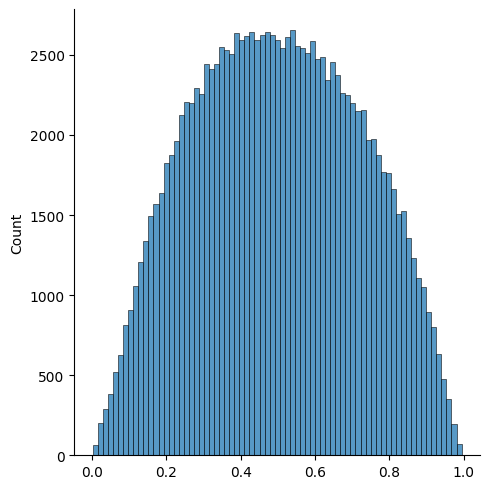

In [58]:
pred_test = np.mean(pred_tests, 0)
df_test['pred'] = pred_test

_ = sns.displot(pred_test)

In [59]:
final_sub = df_test[['ID', 'pred']].copy()
final_sub.to_csv('submission.csv', index=False)

In [60]:
final_sub.head()

,ID,pred
0,2023_1101_1102,0.408234
1,2023_1101_1103,0.266898
2,2023_1101_1104,0.138591
3,2023_1101_1105,0.480422
4,2023_1101_1106,0.655318
